# Лабораторна робота №2

#### Тема: Нейронна мережа із зворотнім поширенням похибки
#### Мета: Вивчити один із методів функціонування нейронних мереж і принципи його застосування

In [1]:
import numpy as np

Цільова функція має вигляд: 
$$f(x_1, x_2, x_3) = x_1^2 + \sin x_2^2 - \tan x_3$$

Датасет отримується шляхом обчислення значень функції в заданих значеннях аргументів $([7, 4, 5])$ та їх варіаціях з кроками $\pm 1$

In [2]:
def goal_func(x):
    return x[:, 0] ** 2 + np.sin(x[:, 1] ** 2) - np.tan(x[:, 2])

In [3]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


def initialize_data(initial_params):  
    x0 = np.array(initial_params)
    steps = [-1, 0, 1]
    X = np.array([x0 + [dx1, dx2, dx3] for dx1 in steps for dx2 in steps for dx3 in steps])
    np.random.shuffle(X)

    D1 = goal_func(X)
    d1_avg = np.mean(D1)
    D2 = [1 if d > d1_avg else 0 for d in D1]
    D = np.array([D1, D2]).T
    return X, D


def get_train_test_data(X, D):
    X_train, X_test = np.array(X)[:20, :], np.array(X)[20:, :]
    D_train, D_test = np.array(D)[:20, :], np.array(D)[20:, :]
    return X_train, D_train, X_test, D_test
    
    
X, D = initialize_data([7, 4, 5])
X_train, D_train, X_test, D_test = get_train_test_data(X, D)

In [4]:
print("(normalized values)")
print("Train data")
for x, d in zip(X_train, D_train):
    print(f"f{x}={d[0]:<.5f}; f(x) > _avg_: {int(d[1])}")
    
print("\nTest data")
for x, d in zip(X_test, D_test):
    print(f"f{x}={d[0]:<.5f}; f(x) > _avg_: {int(d[1])}")

(normalized values)
Train data
f[6 5 4]=34.70983; f(x) > _avg_: 0
f[6 5 6]=36.15865; f(x) > _avg_: 0
f[8 3 4]=63.25430; f(x) > _avg_: 1
f[8 4 6]=64.00310; f(x) > _avg_: 1
f[6 5 5]=39.24816; f(x) > _avg_: 0
f[7 4 5]=52.09261; f(x) > _avg_: 1
f[7 3 6]=49.70312; f(x) > _avg_: 0
f[8 5 6]=64.15865; f(x) > _avg_: 1
f[6 4 4]=34.55428; f(x) > _avg_: 0
f[6 3 6]=36.70312; f(x) > _avg_: 0
f[6 4 6]=36.00310; f(x) > _avg_: 0
f[6 3 4]=35.25430; f(x) > _avg_: 0
f[7 3 5]=52.79263; f(x) > _avg_: 1
f[8 3 5]=67.79263; f(x) > _avg_: 1
f[8 4 4]=62.55428; f(x) > _avg_: 1
f[8 5 4]=62.70983; f(x) > _avg_: 1
f[7 3 4]=48.25430; f(x) > _avg_: 0
f[7 5 5]=52.24816; f(x) > _avg_: 1
f[8 3 6]=64.70312; f(x) > _avg_: 1
f[6 4 5]=39.09261; f(x) > _avg_: 0

Test data
f[7 5 4]=47.70983; f(x) > _avg_: 0
f[6 3 5]=39.79263; f(x) > _avg_: 0
f[8 4 5]=67.09261; f(x) > _avg_: 1
f[7 4 6]=49.00310; f(x) > _avg_: 0
f[7 5 6]=49.15865; f(x) > _avg_: 0
f[8 5 5]=67.24816; f(x) > _avg_: 1
f[7 4 4]=47.55428; f(x) > _avg_: 0


### Архітектура нейронної мережі


<img src="images/densenn.png" width=300 height=300 />

Кількість нейронів у прихованому шарі буде змінна (3, 10, 25)

Алгоритм начання мережі можна поділити на декілька етапів:
- Feed forward
<img src="images/forward.png" width=300 height=300  />
- Backpropagation
<img src="images/cost.png" width=300 height=300 />
<img src="images/back.png" width=500 height=500 />
- Update of weights


In [5]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
def sigmoid(x, derivative=False):
    if derivative:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1. / (1 + np.exp(-x))


class Dense_NN:
    def __init__(self, dims=[3, 3, 2], activation=sigmoid):
        ''' NN Parameters initialization
        It is generally recommended to have weights uniformly distributed 
        while bias weights are usually set equal to zeros at the beginning
        '''
        self.activation = activation
        self.dimensions = dims
        self.N = len(dims) - 1
        self.weights = []
        self.biases = []
        self.scaler = MinMaxScaler()
        
    def initialize(self):
        for i in range(len(self.dimensions)-1):
            p, l = self.dimensions[i:i+2]
            self.weights.append(np.random.uniform(-1, 1, (p, l)))
            self.biases.append(np.zeros((1, l)))
    
    def _loss(self, d, y):
        return 1. / 2 * np.sum((d - y) ** 2)
    
    def _shuffle_data(self, x, d):
        data = list(zip(x, d))
        np.random.shuffle(data)
        x, d = zip(*data)
        x, d = np.array(x), np.array(d)
        return x, d
    
    def _feedforward(self, x):
        cache = {}
        a = x
        cache["a0"] = a
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(a, W) + b
            a = sigmoid(z)
            cache["z"+str(i+1)] = z
            cache["a"+str(i+1)] = a
        return cache, a
    
    def _backpropagation(self, d, y, cache):
        n_samples = d.shape[0]
        z, a = cache["z"+str(self.N)], cache["a"+str(self.N-1)]
        delta = (y - d) * self.activation(z, derivative=True)
        dW, db = [np.dot(a.T, delta) / n_samples], [np.sum(delta, axis=0) / n_samples]
        for i in range(self.N-1, 0, -1):
            z, a = cache["z"+str(i)], cache["a"+str(i-1)]
            delta = np.dot(delta, self.weights[i].T) * sigmoid(z, derivative=True)
            dW.insert(0, np.dot(a.T, delta) / n_samples)
            db.insert(0, np.sum(delta, axis=0) / n_samples)
        return dW, db
    
    def _update(self, learning_rate, dW, db):
        for i in range(self.N):
            self.weights[i] = self.weights[i] - learning_rate * dW[i] 
            self.biases[i] = self.biases[i] - learning_rate * db[i]
    
    def fit(self, X_train, D_train, learning_rate=0.2, epochs=30000):
        self.initialize()
        D_train = self.scaler.fit_transform(D_train)  # first, scale output data to be able to use sigmoid
        
        losses = {}
        for epoch in range(epochs+1):
            x, d = self._shuffle_data(X_train, D_train)
            
            cache, y = self._feedforward(x)  # forward
            dW, db = self._backpropagation(d, y, cache)  # backward
            self._update(learning_rate, dW, db)  # update
            
            # loss
            if not (epoch) % (epochs/10):
                losses[epoch] = self._loss(d, y)
#                 print(f"Epoch: {epoch}  Loss: {self._loss(d, y):<.6f}")
        return losses
                
    def evaluate(self, x):
        _, y = self._feedforward(x)
        y[:,1][y[:,1] > 0.5] = 1
        y[:,1][y[:,1] <= 0.5] = 0
        y = self.scaler.inverse_transform(y)
        return y

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import timeit


Дослідимо точність натренованої мережі при різних кількостях **прихованих нейронів**: 3, 10, 25

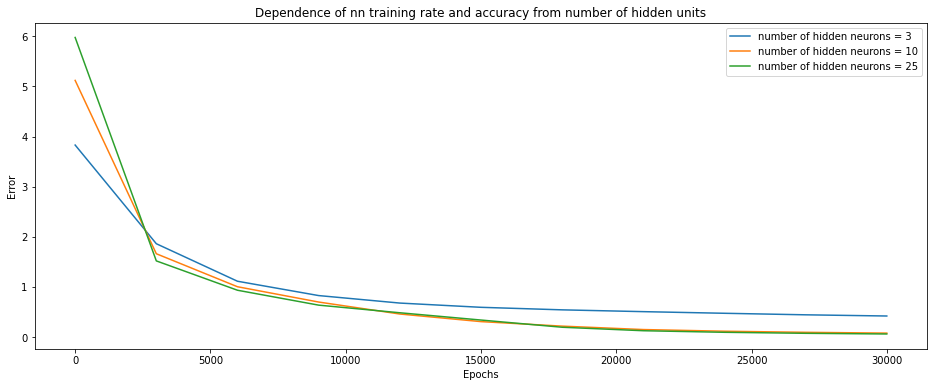

In [52]:
fig = plt.figure(figsize=(16, 6))
test_results = []
time = []
results ={}
n_hidden_neurons = [3, 10, 25]
for k in n_hidden_neurons:
    results[k] = {}
    start = timeit.default_timer()
    nn = Dense_NN(dims=[3, k, 2])
    results[k]["losses"] = nn.fit(X_train, D_train)
    stop = timeit.default_timer()
    results[k]["time"] = stop - start
    results[k]["test evaluation"] = nn.evaluate(X_test)
    plt.plot(results[k]["losses"].keys(), results[k]["losses"].values(), label="number of hidden neurons = " + str(k))
    
plt.title("Dependence of nn training rate and accuracy from number of hidden units")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.show()

In [53]:
print("Training time:")
for k in n_hidden_neurons:
    print(f"(k={k:<2d})  {results[k]['time']:<.6f}s")
print("\nTest set accuracy:")
for i in range(len(X_test)):
    print(f"x={X_test[i]}  f(x)=({D_test[i][0]:<.4f}, {int(D_test[i][1])})", end = " | ")
    for k in n_hidden_neurons:
        print(f"k={k:<2d} f(x)=({results[k]['test evaluation'][i][0]:<.4f}, {int(results[k]['test evaluation'][i][1])})", end=" | ")
    print()

Training time:
(k=3 )  3.819955s
(k=10)  4.234347s
(k=25)  4.253946s

Test set accuracy:
x=[7 5 4]  f(x)=(47.7098, 0) | k=3  f(x)=(51.2649, 1) | k=10 f(x)=(46.5336, 0) | k=25 f(x)=(47.9633, 1) | 
x=[6 3 5]  f(x)=(39.7926, 0) | k=3  f(x)=(36.5450, 0) | k=10 f(x)=(36.0269, 0) | k=25 f(x)=(37.6462, 0) | 
x=[8 4 5]  f(x)=(67.0926, 1) | k=3  f(x)=(64.8671, 1) | k=10 f(x)=(64.9134, 1) | k=25 f(x)=(65.3329, 1) | 
x=[7 4 6]  f(x)=(49.0031, 0) | k=3  f(x)=(47.9632, 0) | k=10 f(x)=(50.6923, 0) | k=25 f(x)=(48.1906, 0) | 
x=[7 5 6]  f(x)=(49.1587, 0) | k=3  f(x)=(52.4530, 1) | k=10 f(x)=(51.6967, 1) | k=25 f(x)=(47.6982, 1) | 
x=[8 5 5]  f(x)=(67.2482, 1) | k=3  f(x)=(65.2392, 1) | k=10 f(x)=(64.6424, 1) | k=25 f(x)=(65.3130, 1) | 
x=[7 4 4]  f(x)=(47.5543, 0) | k=3  f(x)=(48.0937, 0) | k=10 f(x)=(46.8857, 0) | k=25 f(x)=(47.9449, 0) | 


Дослідимо точність натренованої мережі при трьох різних значеннях **learning rate**: 0.05, 0.2, 0.5

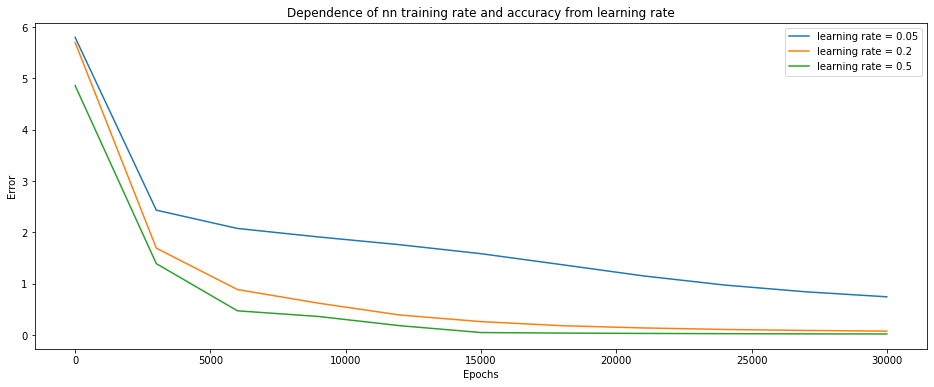

In [50]:
fig = plt.figure(figsize=(16, 6))
test_results = []
time = []
results ={}
learning_rates = [0.05, 0.2, 0.5]
for lr in learning_rates:
    results[lr] = {}
    start = timeit.default_timer()
    nn = Dense_NN(dims=[3, 10, 2])
    results[lr]["losses"] = nn.fit(X_train, D_train, learning_rate=lr)
    stop = timeit.default_timer()
    results[lr]["time"] = stop - start
    results[lr]["test evaluation"] = nn.evaluate(X_test)
    plt.plot(results[lr]["losses"].keys(), results[lr]["losses"].values(), label="learning rate = " + str(lr))
    
plt.title("Dependence of nn training rate and accuracy from learning rate")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc="upper right")
plt.show()


In [51]:
print("Training time:")
for lr in learning_rates:
    print(f"(lr={lr:<.2f})  {results[lr]['time']:<.6f}s")
print("\nTest set accuracy:")
for i in range(len(X_test)):
    print(f"x={X_test[i]}  f(x)=({D_test[i][0]:<.4f}, {int(D_test[i][1])})", end = " | ")
    for lr in learning_rates:
        print(f"lr={lr:<.2f} f(x)=({results[lr]['test evaluation'][i][0]:<.4f}, {int(results[lr]['test evaluation'][i][1])})", end=" | ")
    print()

Training time:
(lr=0.05)  5.014687s
(lr=0.20)  4.411470s
(lr=0.50)  4.482256s

Test set accuracy:
x=[7 5 4]  f(x)=(47.7098, 0) | lr=0.05 f(x)=(50.7350, 1) | lr=0.20 f(x)=(47.0865, 0) | lr=0.50 f(x)=(44.4775, 1) | 
x=[6 3 5]  f(x)=(39.7926, 0) | lr=0.05 f(x)=(39.1552, 0) | lr=0.20 f(x)=(37.3591, 0) | lr=0.50 f(x)=(36.8368, 0) | 
x=[8 4 5]  f(x)=(67.0926, 1) | lr=0.05 f(x)=(62.0479, 1) | lr=0.20 f(x)=(65.6726, 1) | lr=0.50 f(x)=(65.0375, 1) | 
x=[7 4 6]  f(x)=(49.0031, 0) | lr=0.05 f(x)=(49.6023, 0) | lr=0.20 f(x)=(48.3036, 0) | lr=0.50 f(x)=(48.8533, 0) | 
x=[7 5 6]  f(x)=(49.1587, 0) | lr=0.05 f(x)=(49.7323, 1) | lr=0.20 f(x)=(48.2208, 0) | lr=0.50 f(x)=(49.1027, 0) | 
x=[8 5 5]  f(x)=(67.2482, 1) | lr=0.05 f(x)=(61.5523, 1) | lr=0.20 f(x)=(65.2985, 1) | lr=0.50 f(x)=(64.5531, 1) | 
x=[7 4 4]  f(x)=(47.5543, 0) | lr=0.05 f(x)=(52.0601, 1) | lr=0.20 f(x)=(46.8516, 0) | lr=0.50 f(x)=(45.9621, 0) | 
